In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

In [2]:
sns.set(rc={'figure.figsize':(15,5)});
plt.figure(figsize=(15,5));

<Figure size 1080x360 with 0 Axes>

In [3]:
%%time

dtype = {
    'ip':'int32',
    'app': 'int16',
    'device': 'int16',
    'os': 'int16',
    'channel': 'int16',
    'is_attributed':'int8'
}

train = pd.read_csv("train_sample.csv", parse_dates=['click_time', 'attributed_time'], dtype=dtype)

Wall time: 502 ms


In [4]:
train['ct_weekday'] = train.click_time.dt.weekday.astype('uint8')
train['ct_day'] = train.click_time.dt.day.astype('uint8')
train['ct_hour'] = train.click_time.dt.hour.astype('uint8')

## Qual o período de datas do dataset?




In [5]:
print(train.click_time.dt.year.value_counts().sort_index())
print('')
print(train.click_time.dt.month.value_counts().sort_index())

2017    100000
Name: click_time, dtype: int64

11    100000
Name: click_time, dtype: int64


In [6]:
train.click_time.dt.day.value_counts().sort_index()

6     5011
7    32393
8    34035
9    28561
Name: click_time, dtype: int64

In [7]:
train.click_time.dt.dayofweek.value_counts().sort_index()

0     5011
1    32393
2    34035
3    28561
Name: click_time, dtype: int64

- Dados considerando apenas novembro de 2017
- Período de 4 dias (6 a 9 de novembro)
    - Segunda a quinta - ```Monday == 0 … Sunday == 6```

## Frequência de cliques ao longo dos dias e horas

In [8]:
train['click_round'] = train.click_time.dt.round('H')

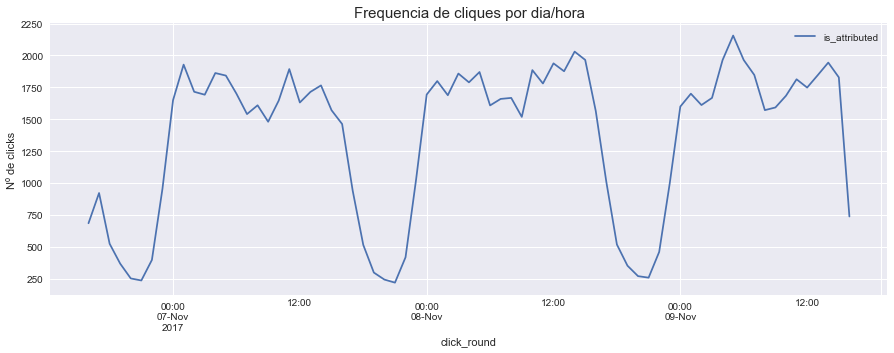

In [9]:
train[['click_round', 'is_attributed']].groupby(['click_round'], as_index=True).count().plot()
plt.title('Frequencia de cliques por dia/hora', fontsize=15)
plt.ylabel('Nº de clicks')
plt.show()

Bom padrão aqui! Cliques sobem, descem um pouco voltam a subir e despencam.

In [10]:
train['click_hour'] = train.click_time.dt.hour

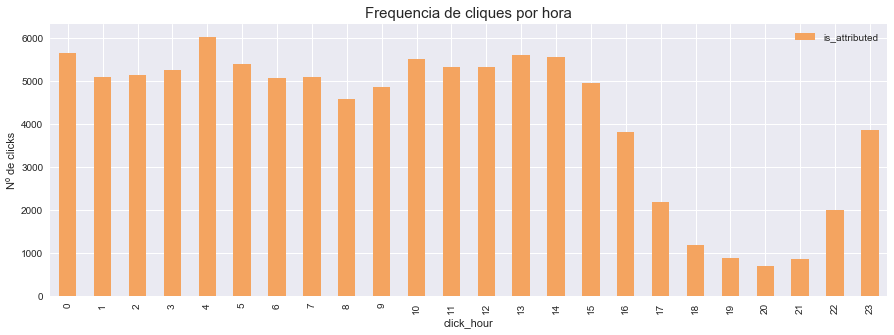

In [11]:
train[['click_hour', 'is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='sandybrown')
plt.title('Frequencia de cliques por hora', fontsize=15)
plt.ylabel('Nº de clicks')
plt.show()

Considerando apenas as horas, é nítido que após as 14h até as 20h a quantidade de cliques diminui gradativamente até voltar a subir às 21h.

## Verificando o balanceamento

Problemas que envolvem fraudes geralmente possuem um alto número de desbalanceamento. Esse dataset não é diferente: apenas  0,2% dos cliques baixaram o app.

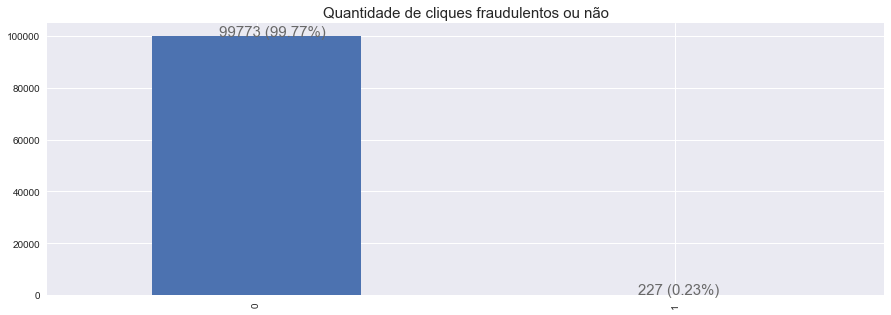

In [12]:
# http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html

ax = train.is_attributed.value_counts().plot(kind='bar')

# Adiciona label em cima das barras
totals = [i.get_height() for i in ax.patches]
for i, total in zip(ax.patches, totals):
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x() + i.get_width()/3.1, 
            i.get_height(),
            '{0} ({1})'.format(str(total), str(round((i.get_height()/sum(totals))*100, 2))+'%'),
            fontsize=15, color='dimgrey')

plt.title('Quantidade de cliques fraudulentos ou não', fontsize=15)
plt.show()

## Tomada de decisão entre clicar em um anúncio e instalar um aplicativo (em horas)

Diferenças que são muito baixas (0.00... horas) provavelmente são decisões tomadas por bots.

In [13]:
train['diff_hour'] = (train.attributed_time - train.click_time)/ np.timedelta64(1, 'm')
train.diff_hour.fillna(-1, inplace=True)

In [14]:
diff_hour = train[(train.diff_hour != -1)].diff_hour.sort_values()
diff_hour.describe()

count    227.000000
mean      74.992878
std      145.089878
min        0.033333
25%        0.875000
50%        3.300000
75%       81.458333
max      772.350000
Name: diff_hour, dtype: float64

Menor diferença: 2 segundos

Maior diferença: 12,8 horas

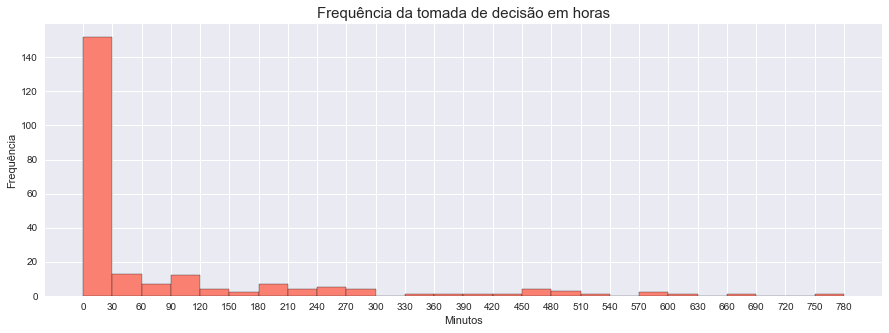

In [15]:
bins= range(0, 800, 30)
plt.hist(diff_hour.values, bins=bins, edgecolor="k", color='salmon')
plt.xticks(bins)
plt.ylabel('Frequência')
plt.xlabel('Minutos')
plt.title('Frequência da tomada de decisão em horas', fontsize=15)
plt.show()

A grande maioria do tempo concentra-se até os primeiros 30 minutos. É bem provável que as fraudes estejam nesse período de tempo:

In [16]:
segs = ((train.attributed_time - train.click_time)/ np.timedelta64(1, 's')).fillna(-1)
segs = segs[(segs != -1) & (segs < 60)].sort_values() # pegando sos o primeiro minuto

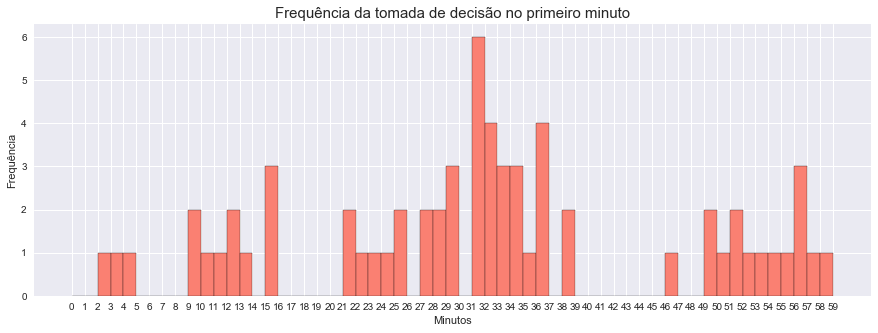

In [17]:
bins= range(0, 60)
plt.hist(segs.values, bins=bins, edgecolor="k", color='salmon')
plt.xticks(bins)
plt.ylabel('Frequência')
plt.xlabel('Minutos')
plt.title('Frequência da tomada de decisão no primeiro minuto', fontsize=15)
plt.show()

Dos cliques que acontecem nos primeiros 30 minutos, quase a metade é feita no primeiro minuto apenas. E desses, a maioria ocorre entre o segundo 24 e 37.

Existe uma separação entre um clique humano e de um bot. O tempo entre o anúncio e o download pode ser uma boa medida. Por exemplo: é possível um humano clicar em um anúncio e fazer o download em 2 segundos?

## Quantidade de cliques

Quantidade total de cliques por feature.



In [18]:
att = train[train.is_attributed == 1]

def qtd_cliques(dct):
    for key, value in dct.items():
        click = att[[key, 'is_attributed']].groupby(key, as_index=True).count().sort_values('is_attributed', ascending=False)
        alll = train[[key, 'is_attributed']].groupby(key, as_index=True).count().sort_values('is_attributed', ascending=False)
        #join
        j = click.join(alll, how='right', lsuffix='_click', rsuffix='_all').sort_values('is_attributed_all', ascending=False).fillna(0)
        j.is_attributed_click = j.is_attributed_click.astype('int32') #convertendo tipo para mostra int
        
        ax = j[:value].plot(kind='barh')
        ax.invert_yaxis()
        plt.xlabel('Nº cliques')
        plt.title('Quantidade de cliques totais e convertidos por {0}'.format(key), fontsize=15)
        plt.legend(loc='lower right')
        
        #adicionando labels nas colunas
        for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            ax.text(i.get_width()+0.5, 
                    i.get_y()+.18,
                    str(round((i.get_width()), 2)), fontsize=11, color='dimgrey')
        

        

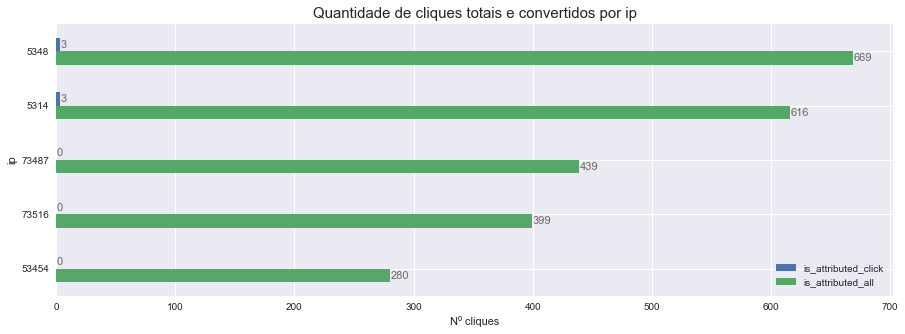

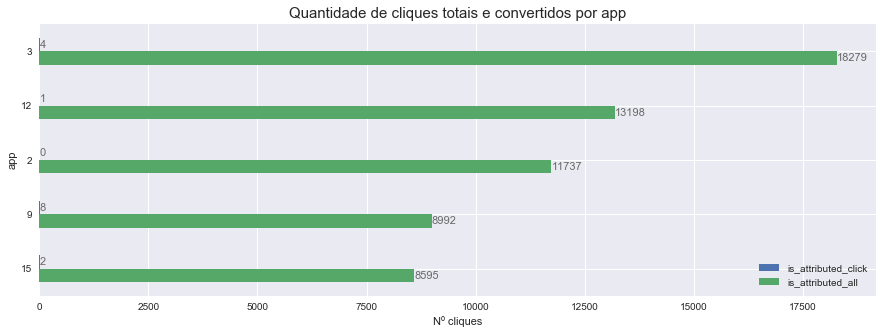

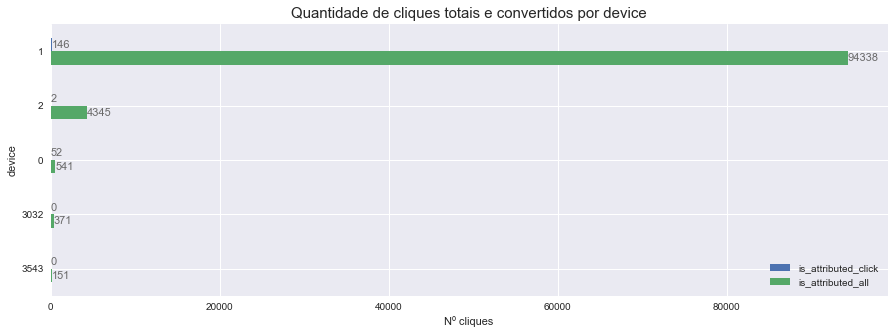

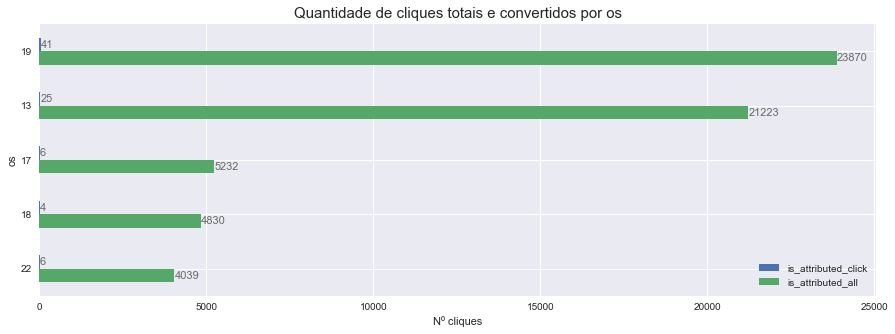

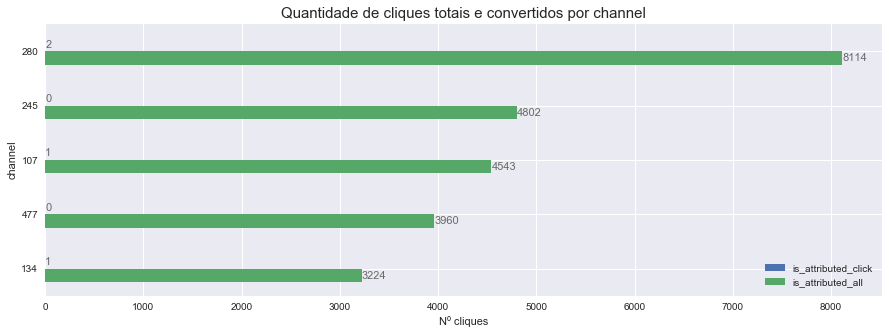

In [19]:
dct_cols = {'ip':5, 'app':5, 'device':5, 'os':5, 'channel':5} # {coluna:qnt_registros}
qtd_cliques(dct_cols)

- Baixo índice de conversões de cliques e downloads
- Um tipo apenas de ```device``` faz praticamente todos os cliques
- Dois tipos de ```os``` realizam a maioria dos cliques
    - Um ```os``` não funciona em um ```device``` diferente do qual foi projetado. Há relação entre as features